# Measuring flash duration for high speed photography

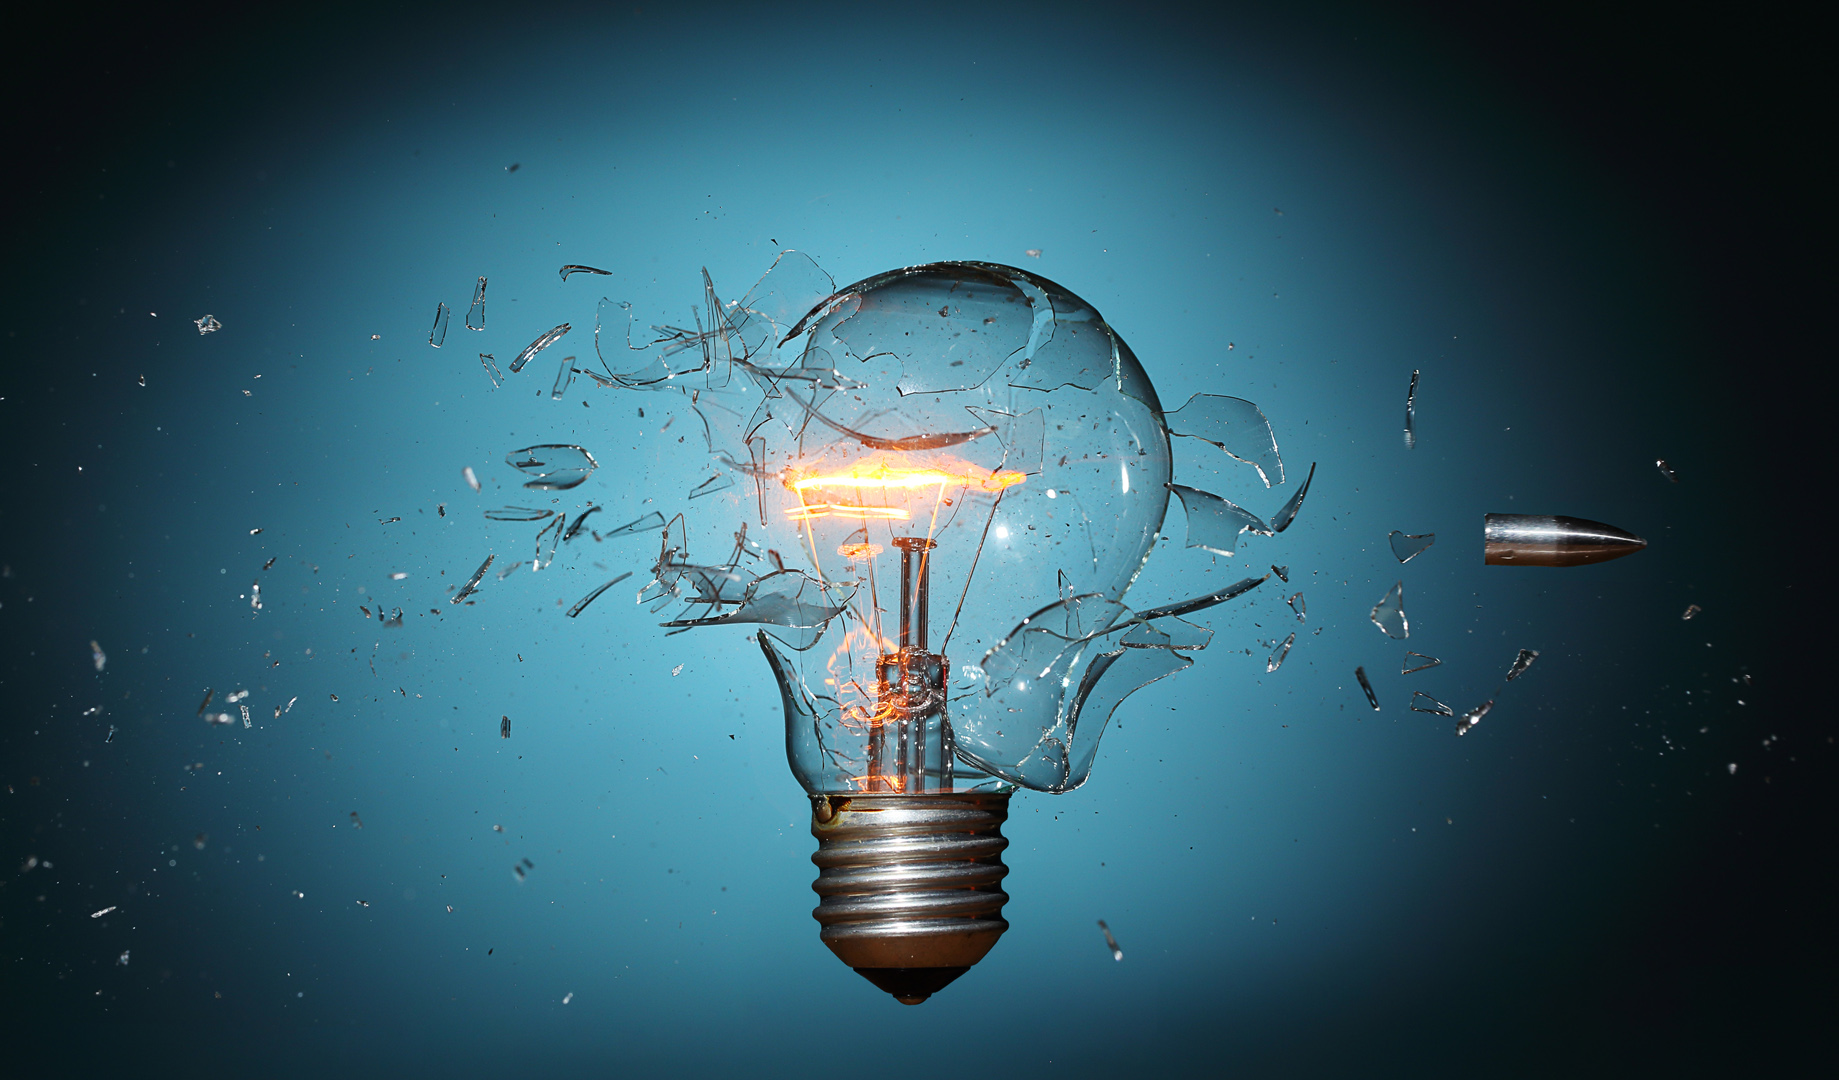

In [1]:
dir = "data/"

from IPython.display import Image
Image(dir + "Light-bulb.jpg")

In the image above, the short exposure time is obtained by taking a picture in the dark, with a shutter time of around 0.1 second, but with an illumination time of 40 $ \mu $s.
<br>
This short illumination time is obtained by lighting by means of a flash, dialed down to its minimum duration.

Since short flash duration is critical in this kind of photography, we investigate here the flash duration time of a couple of flashes.

## Setup
Flash duration is measured by measuring the flash light with a photo diode and displaying the response curve with an oscilloscope. Since direct flash light would overflow a sensitive photo diode, an ND10 filter, which reduces the light by a factor of 1024, is put in front of the diode.
<br>
To hold the diode and the filter, 3D holder was printed.

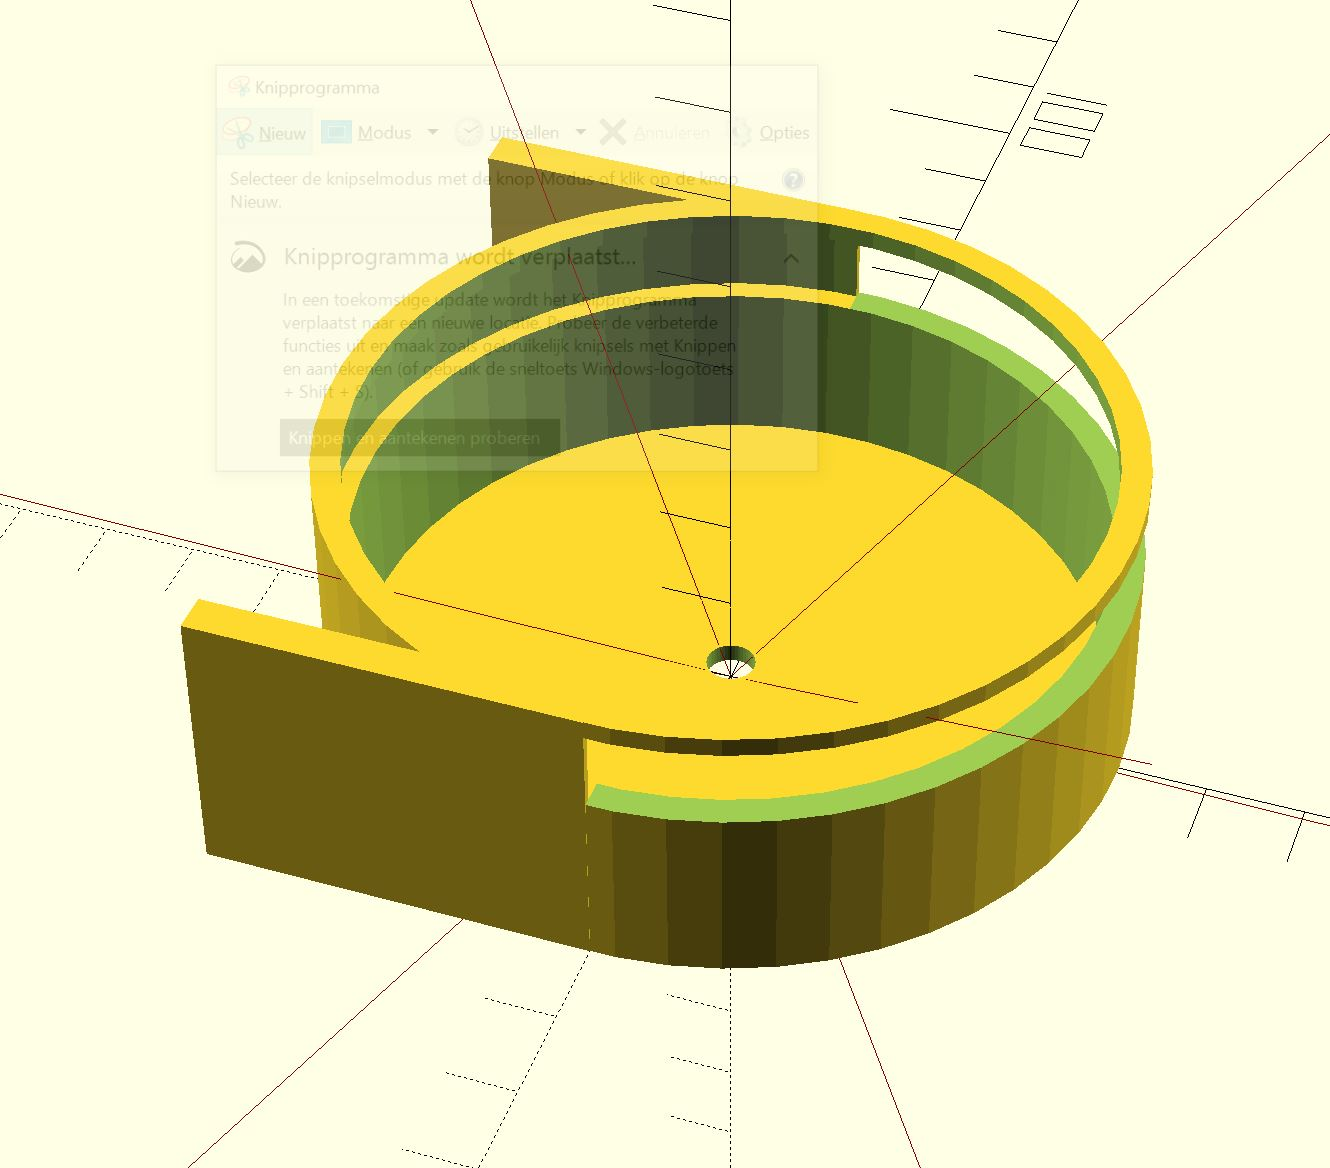

In [2]:
Image(dir + "Flitsmeter-2.JPG", width=600, height=400)

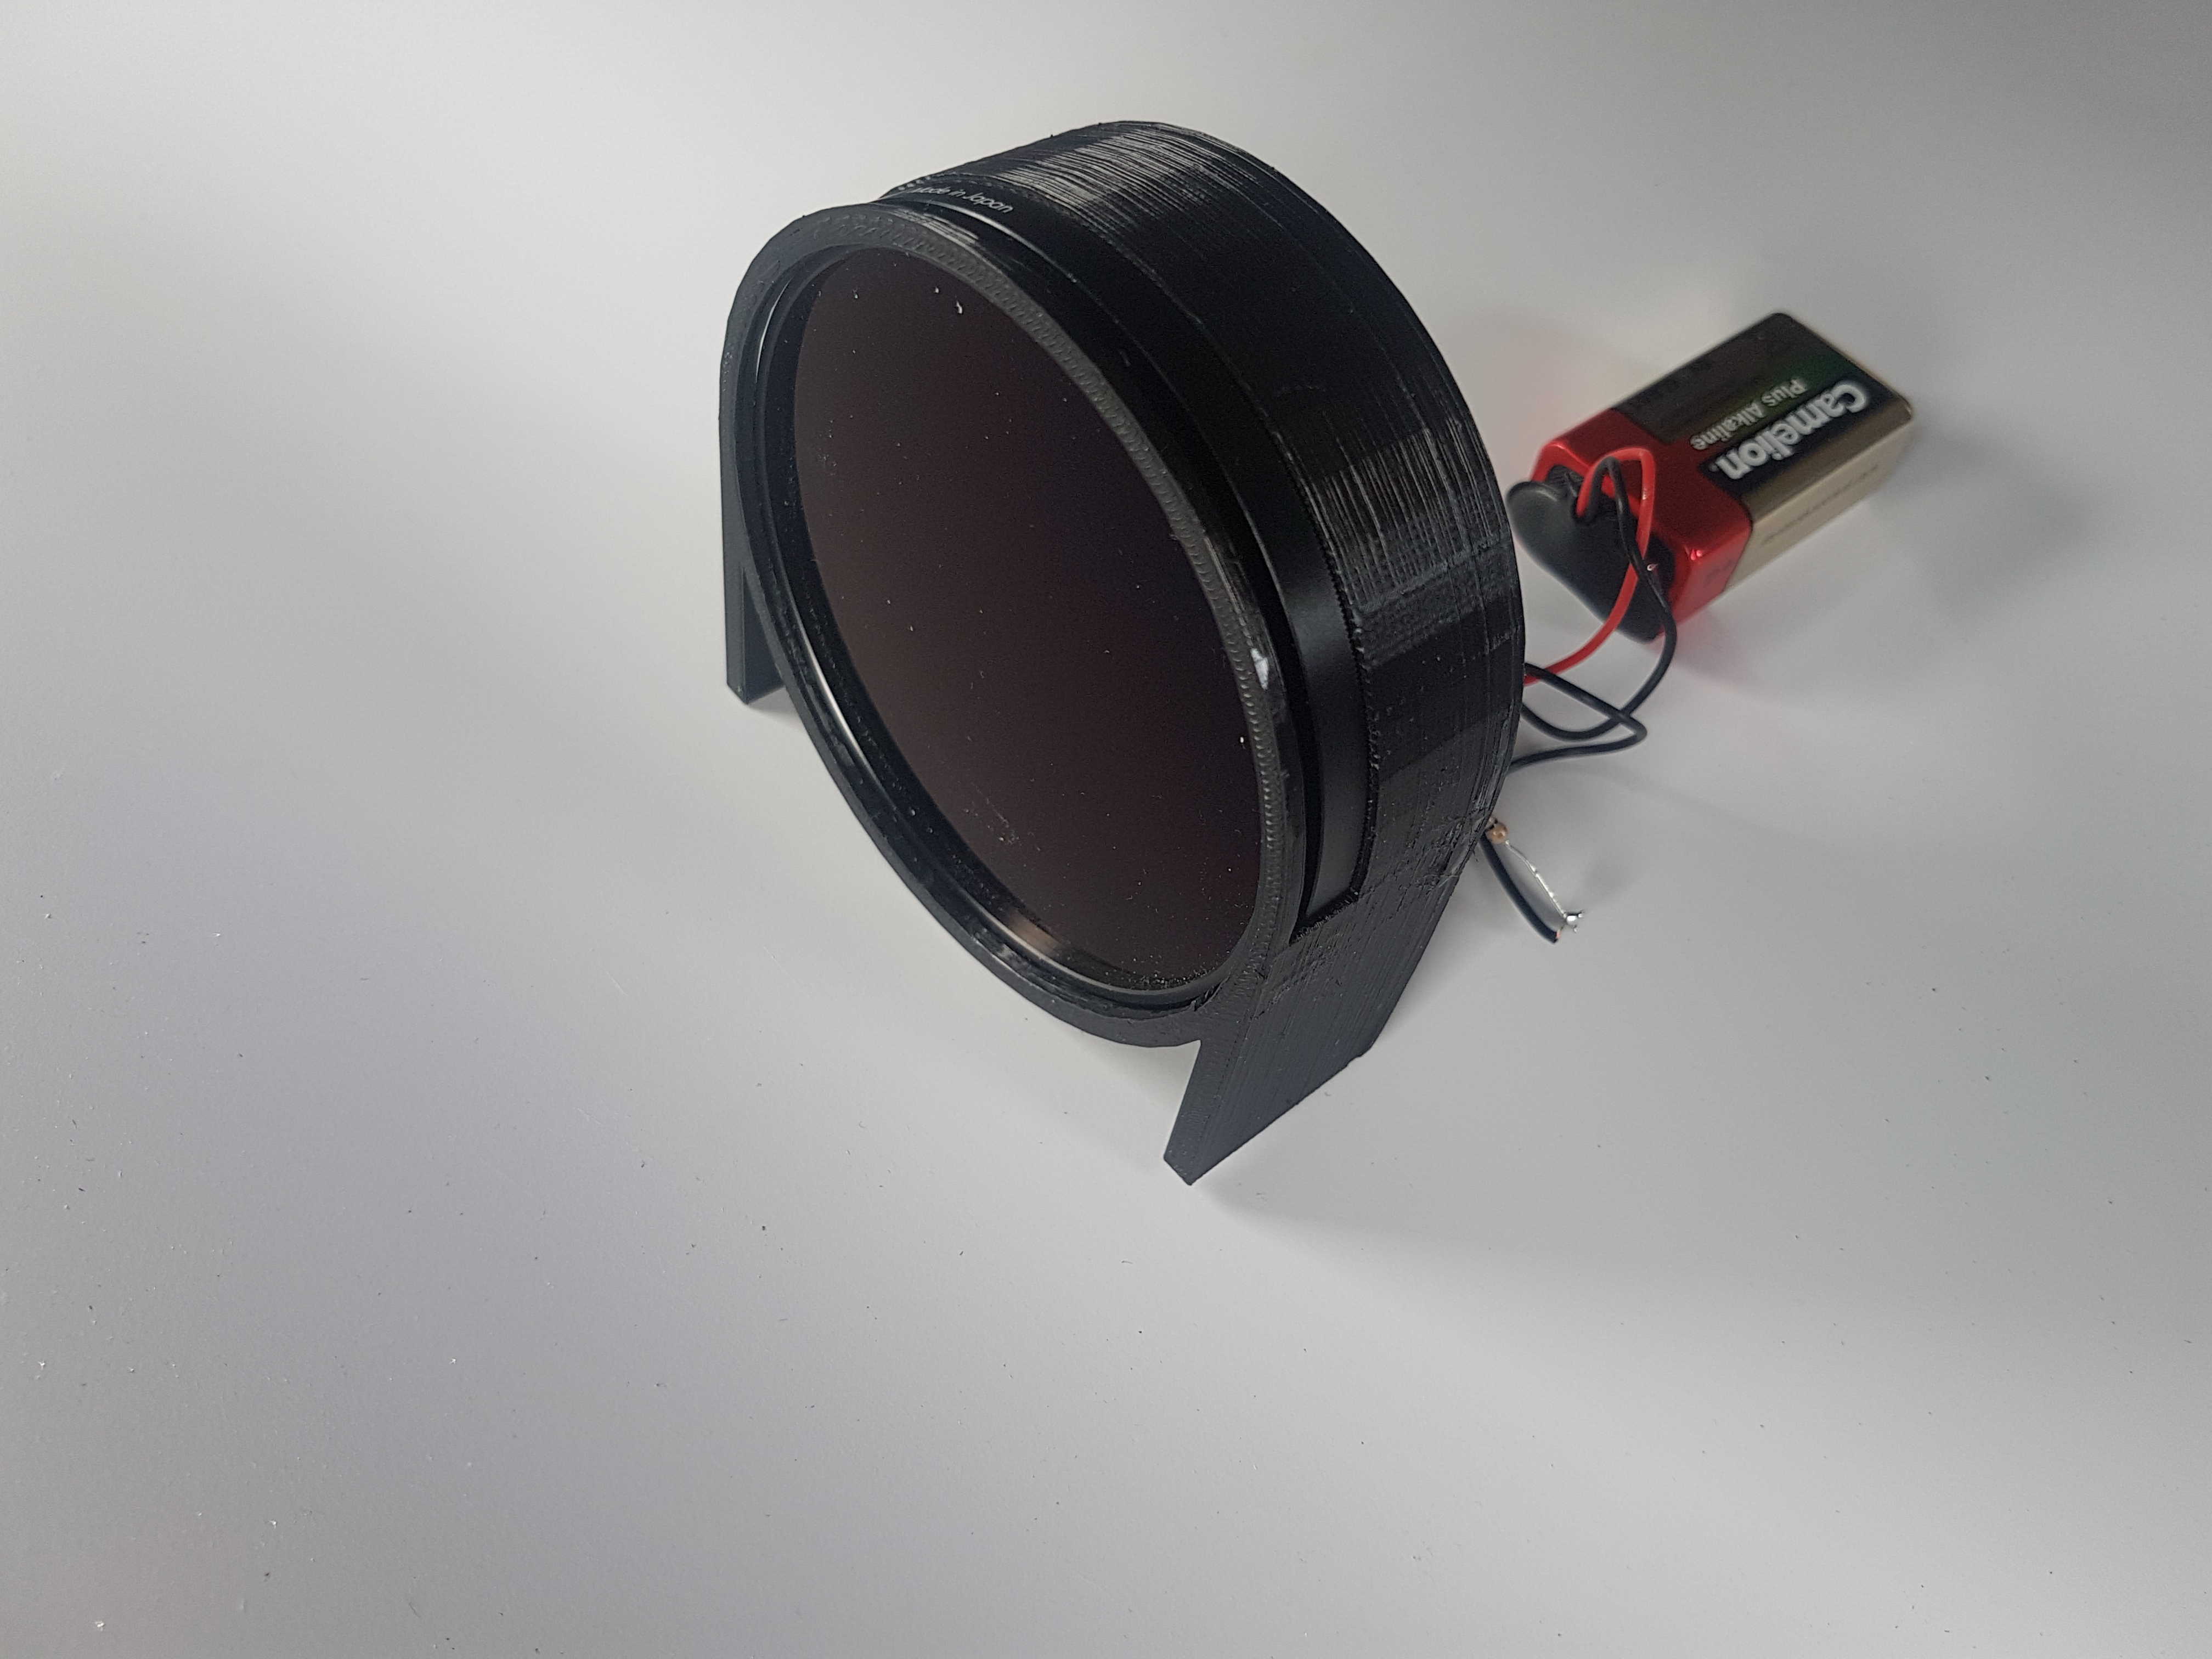

In [3]:
Image(dir + "meter-1.jpg", width=600, height=400)

## Measuring
The actually measuring circuit is very simple. It consists of a photo diode in reverse that generates a current through a resistor once illuminated.

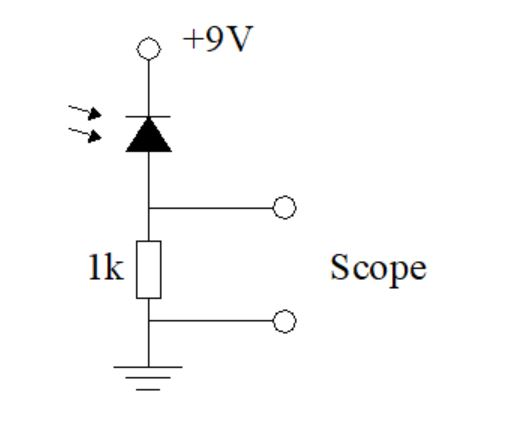

In [4]:
Image(dir + "Lightsensor.JPG", width=200, height=200)

Images on the oscilloscope show a typically wave form for the light intensity.

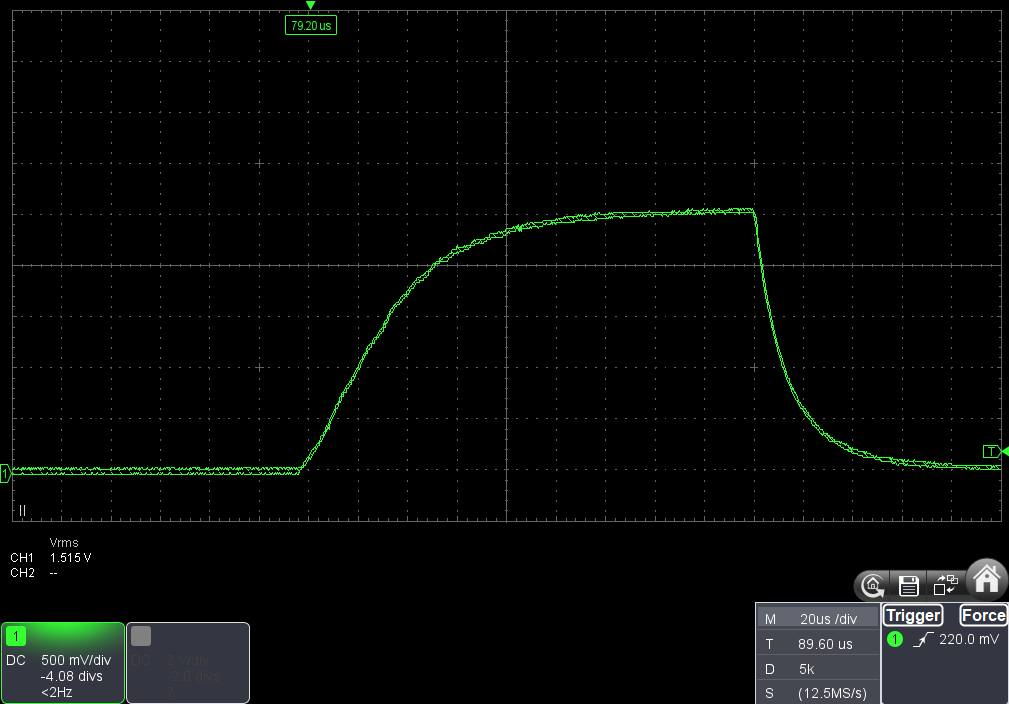

In [5]:
Image(dir + "measure.png", width=600, height=400)

# Processing the wave-forms
For a given flash angle (we picked 28mm, since that is supported by most flashes) and distance between flash and sensor (45 cm), a waveform can be captured for every supported flash intensity. Typical high-end flashes support an intensity from 1 (full power flash), down to 1/128 in steps of 1/2.
<br>
Since typical flash sync time is 1/200 for most camera's and flashes, we expect full power to take around 5 ms. This would mean the lowest power (fastest flash) would be 5/128 ms, width is around 40 $ \mu s $.
<br>
Each wave-form is saved a a cvs (comma-separated) file. Each line consist of (index, time(ms), level(V)) triples.
Each such file is read and transformed into a list of time-stamps and a list of levels.
<br>
As can be seen in the wave-form above, the signal suffers from high-frequency sampling noise from the oscilloscope AD-converter. We therefore apply a low-pass order 5 Butterworth filter to remove this component and get a smoother signal.

First we need some imports.

In [6]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import csv
from scipy import signal

The butterworth filter is inspired from this website: https://dsp.stackexchange.com/questions/49460/apply-low-pass-butterworth-filter-in-python

In [7]:
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=5):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def lp_filter(time, values):
    fs = 1/(time[1]-time[0])  # Sampling frequency in MHz
    return butter_lowpass_filter(values, fs/10, fs)

The csv-file is read and we obtain return the second and third elements of every line. As the time stamp run down for some unknown reason, we invert them.

In [8]:
def get_signal(filename, time_col=1, data_col=2):
    with open(filename, newline='') as csvfile:
        data = list(csv.reader(csvfile, delimiter=','))
        x = data[1:]
        indices = [ -1000*float(l[time_col]) for l in x ] # convert to us.
        values  = [ float(l[data_col]) for l in x ]
        return indices, values

In [9]:
class Signal:
    def __init__(self, speed, times, values):
        self.speed  = speed
        self.times  = np.array(times)
        self.values = np.array(values)

The next function gathers all waveforms from files \<dir\>/\<sub\>/\<pre\>-\<n\>.csv for \<n\> in list \<r\>. The value is corresponds to the inverse of the flash power, and ranges typically from 128 to 1.

We will group all the signals for a certain flash type in a new class Flash.

In [10]:
class Flash:
    def __init__(self, name, speeds, signals):
        self.name    = name
        self.speeds  = speeds
        self.signals = signals

In [11]:
def get_flash(dir, sub, pre, r, filter=True):
    signals = []
    for i in r:
        filename = "%(d)s/%(s)s/%(f)s-%(x)03d.csv" % {"d":dir, "s":sub, "f":pre, "x":2**i}
        #print(filename)
        indices, values = get_signal(filename)
        if filter: values = lp_filter(indices, values)
        signal = Signal(i, indices, values)
        signals.append(signal)
    return Flash (pre, r, signals)

The following function plots all signals in a list in one plot.

In [12]:
def plot_signal(signals, title, labels=[]):
    figure(figsize=(15, 6), dpi=80)
    for j, s in enumerate(signals):
        if labels==[]: label = "1/%(x)d" % {"x":2**s.speed}
        else: label = labels[j]
        plt.plot(s.times, s.values, label=label)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.xlabel("time(us)")
    plt.show()

## The Canon Speedlite 580EX II flash
We read the signals from all saved waveforms files.

In [13]:
canon_speeds = range(7,-1,-1)
canon_flash  = get_flash(dir, "580EXII", "580", canon_speeds)

We can then plot the waveform for full power. As can be seen, this indeed takes around 5 ms, though the initial intensity is far higher than the final.

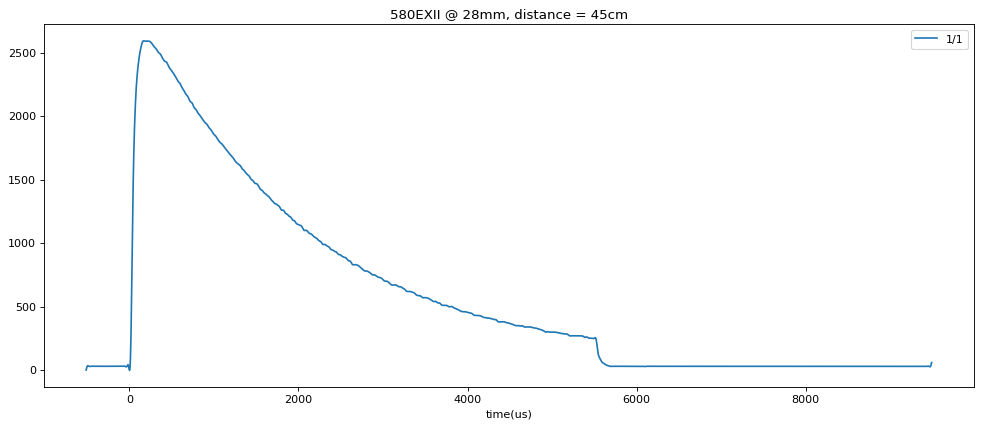

In [14]:
plot_signal(canon_flash.signals[7:], "580EXII @ 28mm, distance = 45cm")

Next we can plot all flash durations, from 1/128 up 1/2. We leave out full power, since that would push all other curves down to the left.

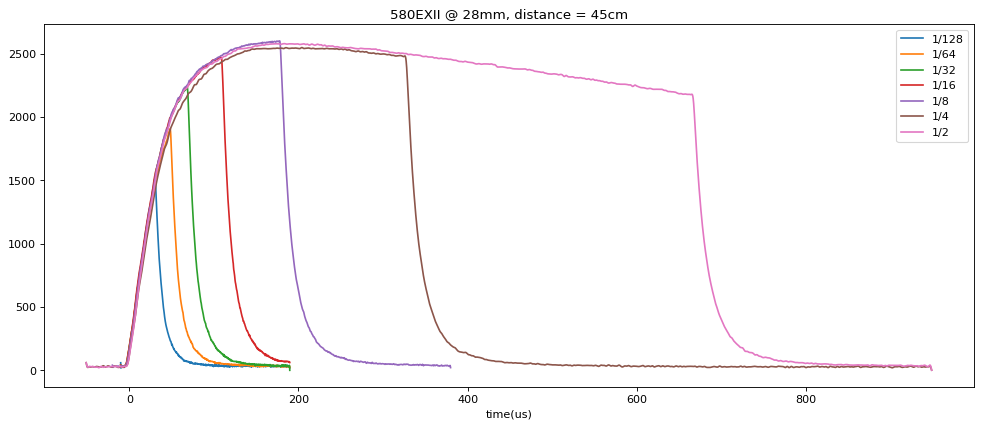

In [15]:
plot_signal(canon_flash.signals[:7], "580EXII @ 28mm, distance = 45cm")

Since we are interested in the shortest flash duration, let's zoom in on the left.

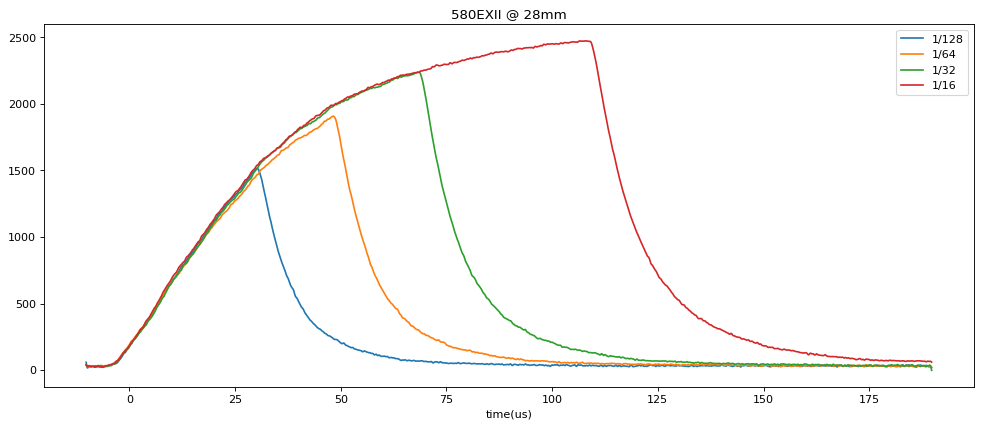

In [16]:
plot_signal(canon_flash.signals[:4], "580EXII @ 28mm")

As can be seen, the shortest duration for 1/128 is indeed around 40 $ \mu $s

## The Sigma EF-500 DG Super
This is a somewhat older flash which does as well support the range 1/128 up to full power.

As can be seen, full power is similar to the Speedlite, but is not being cut-off around 5 ms.

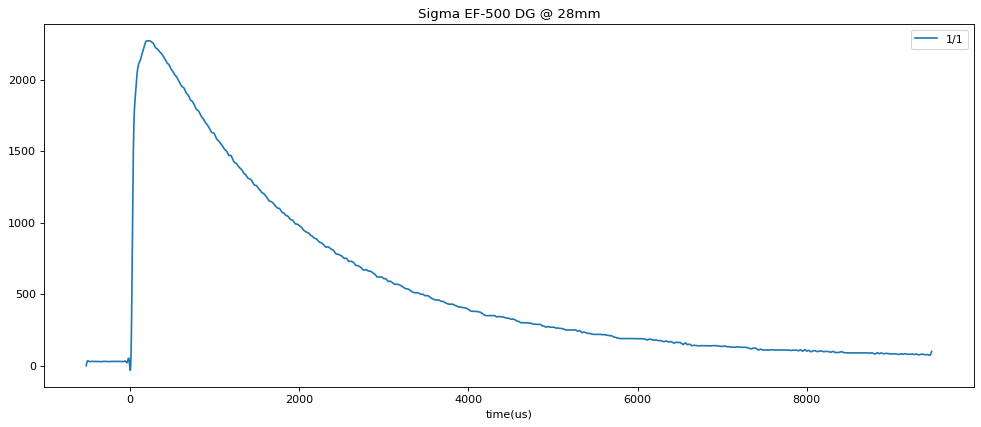

In [17]:
sigma_speeds = range(7,-1,-1)
sigma_flash  = get_flash(dir, "Sigma-EF-500-DG", "Sigma", sigma_speeds)
plot_signal(sigma_flash.signals[7:], "Sigma EF-500 DG @ 28mm")

The range from 1/128 to 1/2 also is very close to the Speedlite

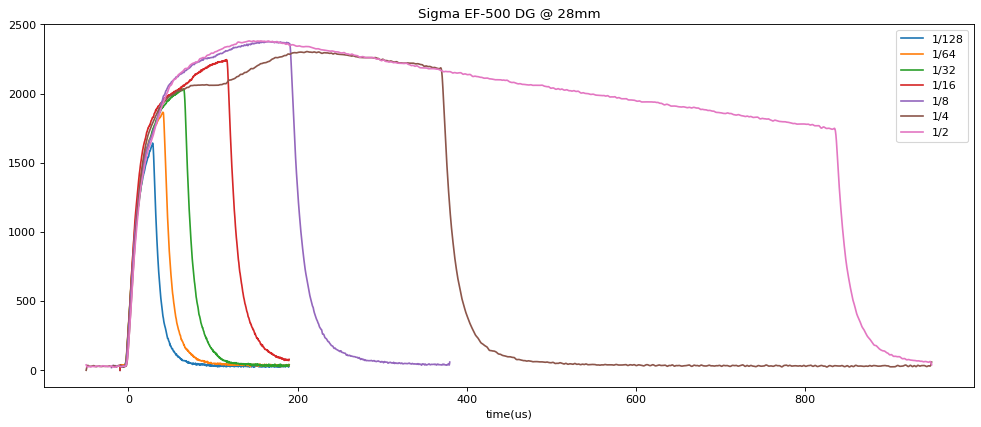

In [18]:
plot_signal(sigma_flash.signals[:7], "Sigma EF-500 DG @ 28mm")

As well  as the short durations.

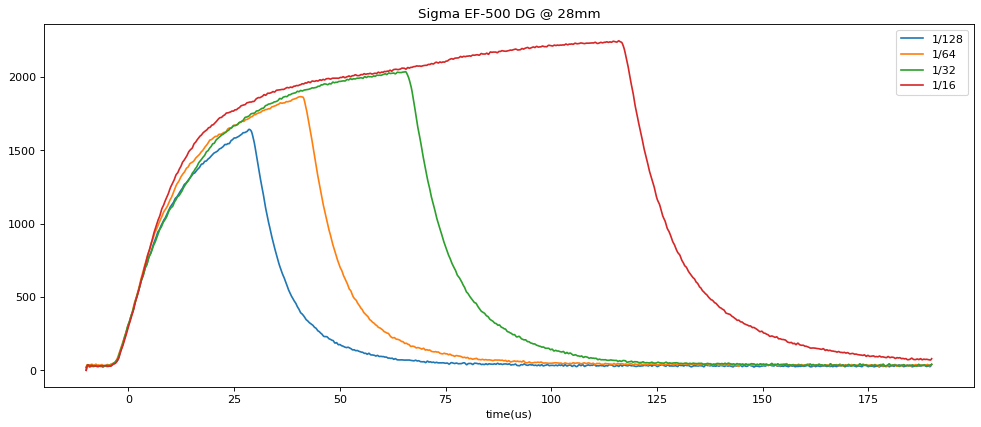

In [19]:
plot_signal(sigma_flash.signals[:4], "Sigma EF-500 DG @ 28mm")

Let's compare the shortest duration 1/28 for both flashes.

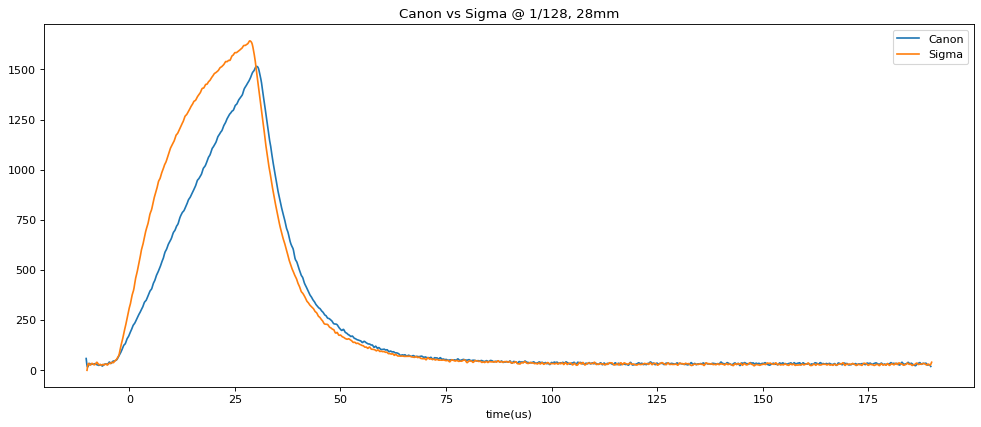

In [20]:
plot_signal([canon_flash.signals[0], sigma_flash.signals[0]],
            "Canon vs Sigma @ 1/128, 28mm", labels=["Canon", "Sigma"])

It can be seen that the curve for the Sigma flash is slightly higher as well as steeper than that of the Speedlite. Therefore, the Sigma will have some (small) advantage for high speed photography.

## The Canon Speedlite 540EZ
I happened to have an older Speedlite, which runs down to 1/64 only. Let's see what it does.

First of all, for power and half power are very similar, which make half power not very useful on this flash.

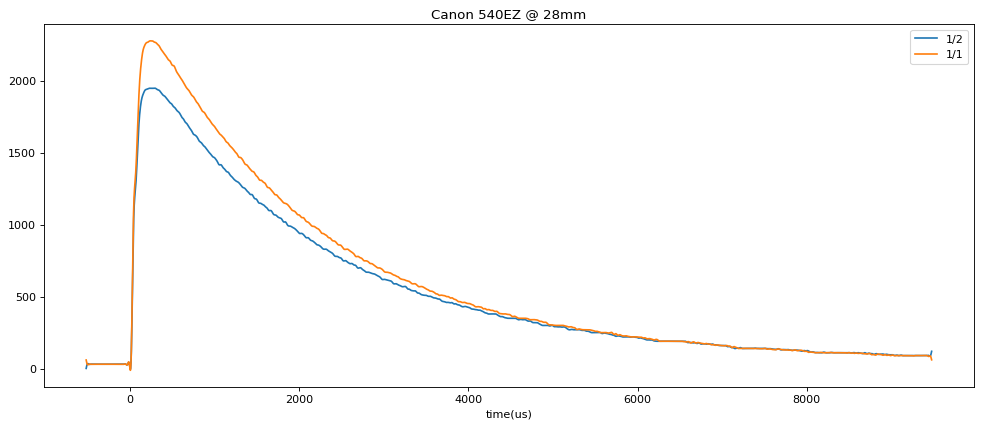

In [21]:
canon_540_speeds = range(6,-1,-1)
canon_540_flash  = get_flash(dir, "540EZ", "540",  canon_540_speeds)
plot_signal(canon_540_flash.signals[5:], "Canon 540EZ @ 28mm")


The shorter durations form a similar pattern, with 1/64 taking about 100 $ \mu $s, which is slightly slower than expected.

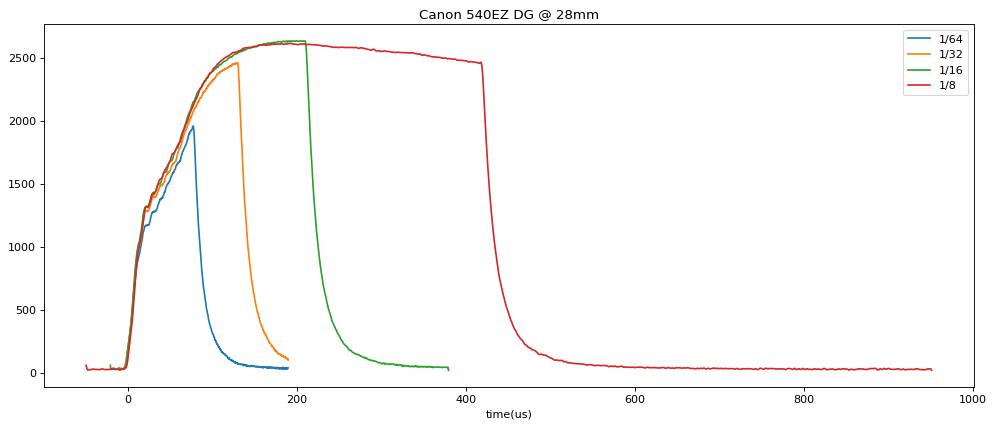

In [22]:
plot_signal(canon_540_flash.signals[:4], "Canon 540EZ DG @ 28mm")

Let's compare all three flashes at 1/64.

As can be seen, the Sigma again has the most narrow curve of around 60 $ \mu $ s, the 580 Speedlite is somewhat slower with about 70 $ \mu $s, while the older Speedlite takes about 90 $ \mu $s.

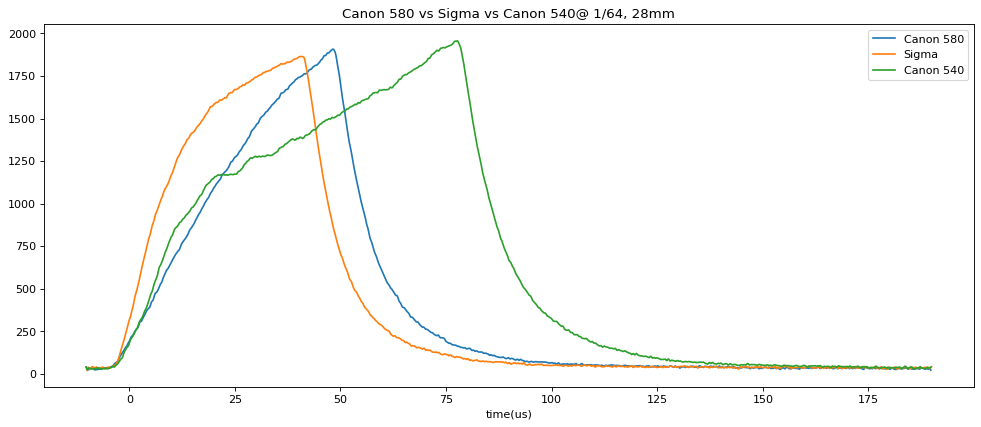

In [23]:
plot_signal([canon_flash.signals[1], sigma_flash.signals[1], canon_540_flash.signals[0]], 
            "Canon 580 vs Sigma vs Canon 540@ 1/64, 28mm", labels=["Canon 580", "Sigma", "Canon 540"])

## The energy of the signals
The plots above give some indication of the energy of the signals, here we will quantize that notion and compare them.

First we extend the plot_signal function to draw some horizontal lines at a certain percentage of the top value.

In [24]:
def plot_signal(signals, title, labels=[], lines=[]):
    figure(figsize=(15, 6), dpi=80)
    for j, s in enumerate(signals):
        if labels==[]: label = "1/%(x)d" % {"x":2**s.speed}
        else: label = labels[j]
        plt.plot(s.times, s.values, label=label)
    plt.title(title)
    plt.legend(loc="upper right")
    plt.xlabel("time(ms)")
    top   = max ([ max(s.values) for s in signals ])
    begin = min ([ min(s.times)  for s in signals ])
    end   = max ([ max(s.times)  for s in signals ])
    for l in lines:
        plt.plot([begin, end],[top*l,top*l],'--')
        t = "%(x)d%%" % {"x":l*100}
        plt.text(end, top*l+30, t, ha='center', va='center')
    plt.show()

We can draw two lines at 50% and 10% of the top of the curves.

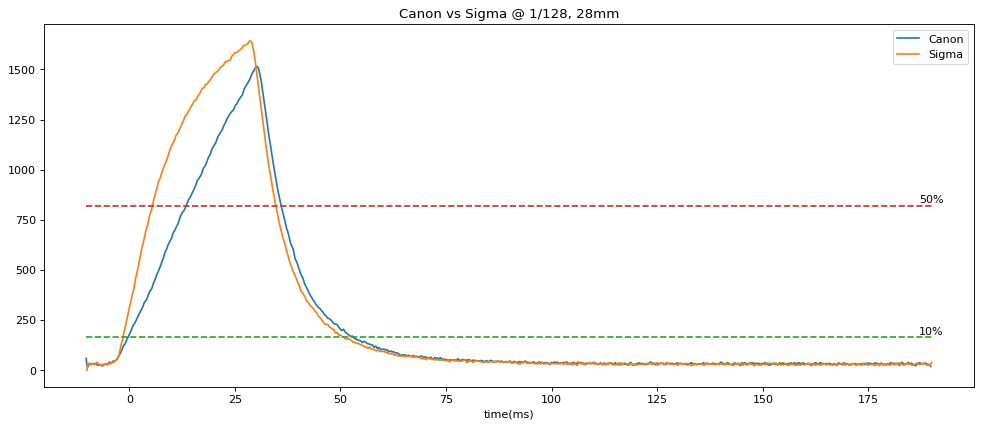

In [25]:
plot_signal([canon_flash.signals[0], sigma_flash.signals[0]], "Canon vs Sigma @ 1/128, 28mm",
            labels=["Canon", "Sigma"], lines=[0.1, 0.5])

This Sigma flash seems to produce more light above the 10% line. However, to quantify that, we need to compute the energy of the signal.

### Energy computation
The energy can be computed by integrating a signal over its interval. Of course, this is not the energy of the light from the flash, rather the energy as produced by the light detector, but it will be proportional to the light energy.

In [26]:
def integrate(x, y):
    e = 0
    z = []
    x0 = x[0]
    for (x1, y1) in zip(x,y):
        e += (x1-x0)*y1
        x0 = x1
        z.append(e)
    return(x,z)

In [27]:
def energy (signal):
    (t, e) = integrate (signal.times, signal.values)
    return e[-1]

print ("Energy:", energy(canon_flash.signals[0]))

Energy: 46428.06846468024


Especially for the faster signals, this energy value is offset by the ground energy, which is a small ripple in the dark state. It is estimated by taking the average of the first 1% samples.

In [28]:
import statistics

def ground_energy(signal):
    start = signal.values[:len(signal.values)//100]
    return statistics.mean(start)*(signal.times[-1]-signal.times[0])

print ("Ground energy:", ground_energy(canon_flash.signals[0]))

Ground energy: 6100.124865995134


Now we can plot the energies as a function of the flash duration. We expect it to approach a straight line.

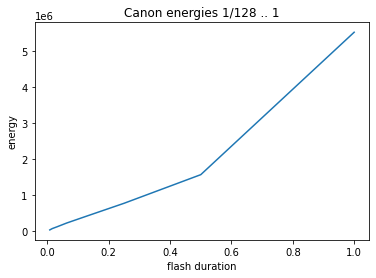

In [29]:
def plot_energies(steps, signals):
    energies = [ energy(s) - ground_energy(s)for s in signals ]
    l = [ 0.5**i for i in steps]
    plt.plot(l, energies)

plt.title("Canon energies 1/128 .. 1")
plt.xlabel("flash duration")
plt.ylabel("energy")
plot_energies(canon_flash.speeds, canon_flash.signals)

The full flash energy does deviate from the straight line, which is to be expected, since it just fully drains the flash charge, let's leave it out.

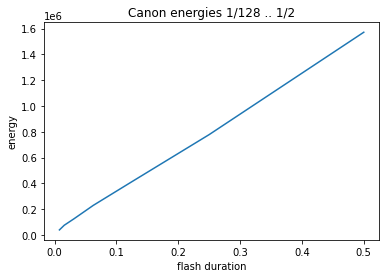

In [30]:
plt.title("Canon energies 1/128 .. 1/2")
plt.xlabel("flash duration")
plt.ylabel("energy")
plot_energies(canon_flash.speeds[:-1], canon_flash.signals[:-1])

That looks good!

Let's look at the Sigma flash.

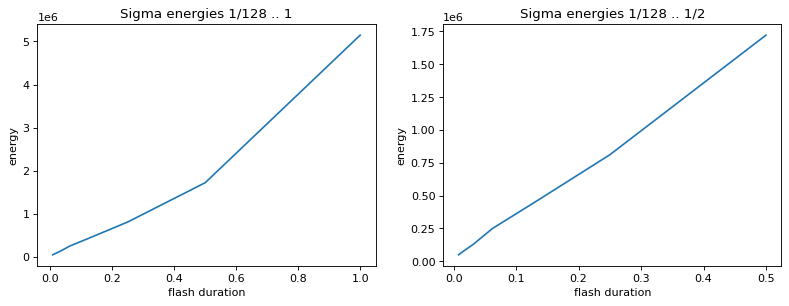

In [31]:
figure(figsize=(12, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.xlabel("flash duration")
plt.ylabel("energy")
plt.title("Sigma energies 1/128 .. 1")
plot_energies(sigma_flash.speeds, sigma_flash.signals)

plt.subplot(1, 2, 2)
plt.xlabel("flash duration")
plt.ylabel("energy")
plt.title("Sigma energies 1/128 .. 1/2")
plot_energies(sigma_flash.speeds[:-1], sigma_flash.signals[:-1])

### Finding the bulk of the energies
Let's now compute the energy above a certain line in the curve, such that e.g. 90% of the *energy* is above that line (as compared to 90% of the height of the curve, as was shown above). We can then see how wide the curve above that line is and in that way, compare the flashes.

To do that we need to integrate the curve vertically, until we have reached a level of 10%.

First we define a function that computes the width of the curve, as a function of the distance from the top. Here we assume that the top is unique, and that the function is sufficiently smooth so we can iteratively find the widths by traversing to the left and right from the top position.

In [32]:
def curve_width(signal, steps=1000):
    top = max (signal.values)
    top_idx = signal.values.argmax()
    widths, heights = [], []
    x0, x1 = top_idx, top_idx
    step = top/steps
    for y in np.arange(top, 0, -step):
        #print (x0, x1, y)
        while x1 < len(signal.values) and signal.values[x1] > y: x1 += 1
        while x0 >= 0 and signal.values[x0] > y: x0 -= 1
        if x0 >= 0 and x1 < len(signal.values):
            heights.append(top-y)
            widths.append(signal.times[x1]-signal.times[x0])
    return heights, widths

Let's plot the widths as a function of the distance from the top. This will be a monotonically rising function.

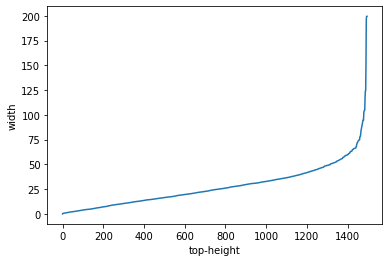

In [33]:
heights, widths = curve_width(canon_flash.signals[0])
plt.xlabel("top-height")
plt.ylabel("width")
plt.plot(heights, widths)

When we integrate this widths function, we compute the energy again. Since the widths as computed will be approximate, this version of the energy will always be smaller than the one obtained by integrating the original curve. Especially, we can expect the ground energy to be missing, since this is represented as a ripple.

Energy: 41829.29724898789


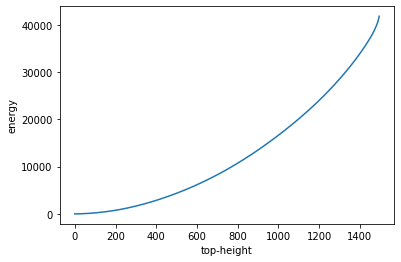

In [34]:
(x1,y1) = integrate(heights, widths)
print ("Energy:", y1[-1])
plt.xlabel("top-height")
plt.ylabel("energy")
plt.plot(x1,y1)

Now we have the machine to find the energy bar for a given fraction of the total energy, as well as the width of the curve at the position of this bar.
<br>
For the Speedlite, this is about 67 $ \mu $s.

In [35]:
def find_bar(signal, p):
    top = max(signal.values)
    (h,w) = curve_width(signal)
    (x1,y1) = integrate(h,w)
    e_max = y1[-1]
    for (i,(x,y)) in enumerate(zip(x1,y1)):
        if y >= e_max*p:
            return w[i], (top-x)/top

width, bar = find_bar(canon_flash.signals[0], 0.9)
print(width, bar)

74.56 0.03799999999994037


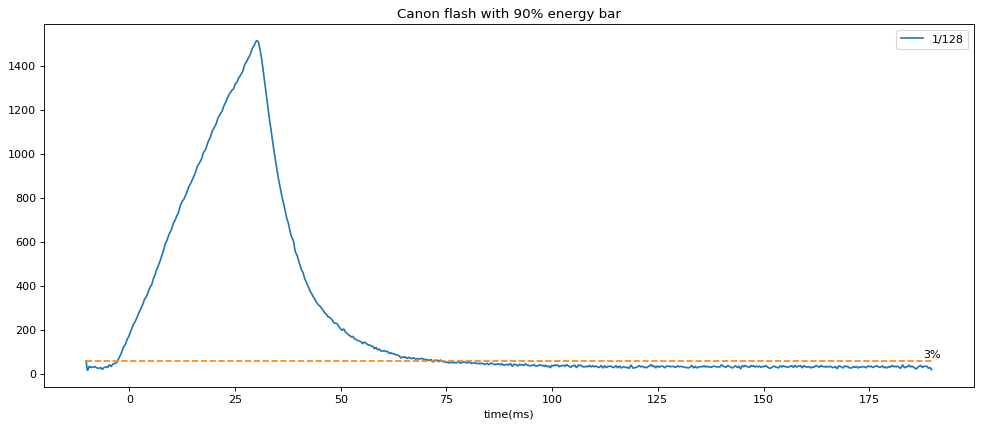

In [36]:
plot_signal([canon_flash.signals[0]], "Canon flash with 90% energy bar", lines=[bar])

Likewise, we can compute the duration in which 90% of the light for the Sigma is emitted. This is about 63 $ \mu $s, so we conclude that both flashes will be equally useful for high speed photography.

64.28 0.050000000000028806


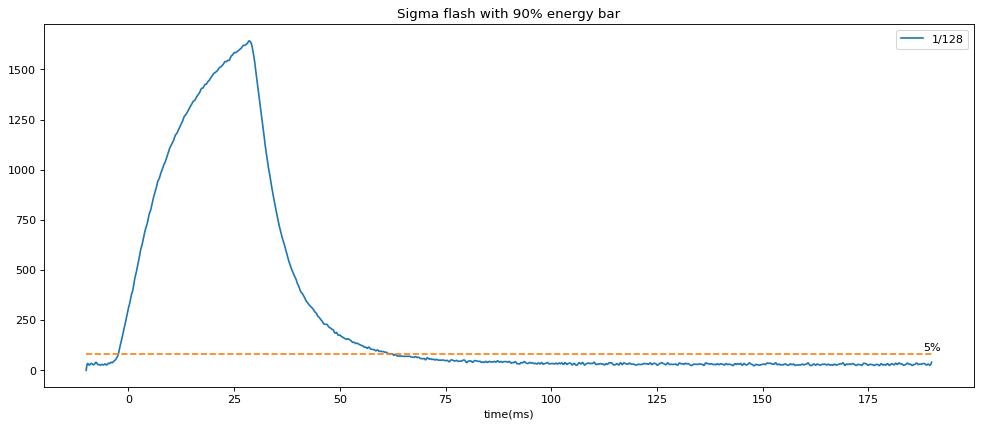

In [37]:
width, bar = find_bar(sigma_flash.signals[0], 0.9)
print (width, bar)
plot_signal([sigma_flash.signals[0]], "Sigma flash with 90% energy bar", lines=[bar])

## Comparing the Canon Sigma flash pulse widths
We can now plot a chart comparing the widths of the two flashes for all their speeds.

In [38]:
def find_widths (signals, p):
    return [ (find_bar (s,p))[0] for s in signals ]

canon_widths = find_widths(canon_flash.signals, 0.9)
sigma_widths = find_widths(sigma_flash.signals, 0.9)

print (canon_widths)
print (sigma_widths)

[74.56, 92.60000000000001, 112.44, 148.64000000000001, 228.4, 377.6, 712.8000000000001, 5534.0]
[64.28, 78.03999999999999, 102.44, 154.60000000000002, 238.64, 417.0, 875.5999999999999, 7084.0]


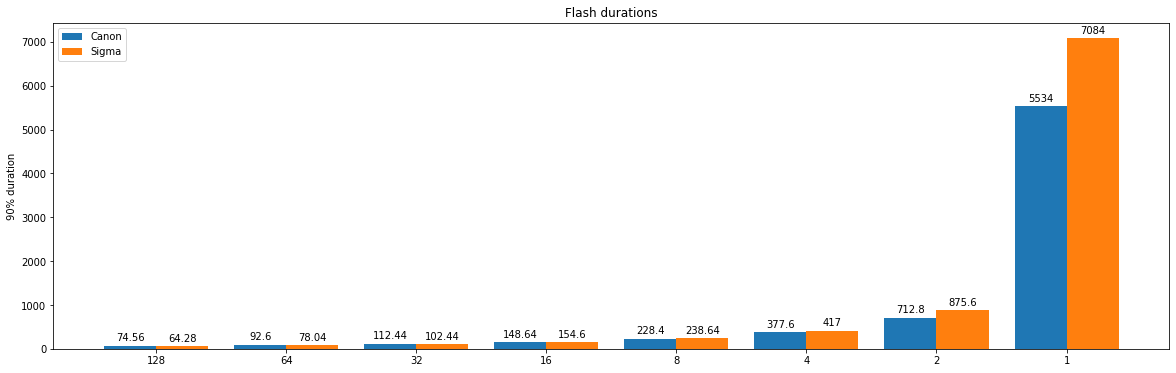

In [39]:
labels = [ 2**speed for speed in canon_flash.speeds ]

x = np.arange(len(canon_widths))*10  # the label locations
width = 4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, canon_widths, width, label='Canon')
rects2 = ax.bar(x + width/2, sigma_widths, width, label='Sigma')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('90% duration')
ax.set_title('Flash durations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

#fig.tight_layout()
fig.set_size_inches(20, 6)

plt.show()

## Using a fast pin diode
After writing this notebook, I obtained a very fast pin photo diode. The original one was a generic diode with a rise and fall time of 15 $ \mu $s, which is pretty close to the minimum flash duration. This might distort the measurements. The pin diode has a response time of 5 ns (!). It is far less sensitive though, therefore the ND filter has to be removed.

Let's have a look at the results.

In [40]:
canon_flash_pin  = get_flash(dir, "580EXII-pin", "pin", canon_speeds)

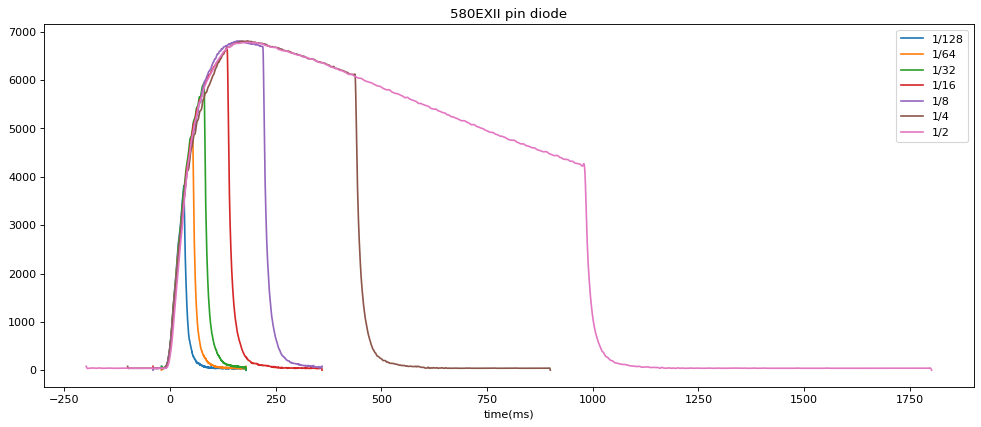

In [41]:
plot_signal(canon_flash_pin.signals[:-1], "580EXII pin diode")

The curves look very similar to the original ones. But let us inspect the fasted pulses.

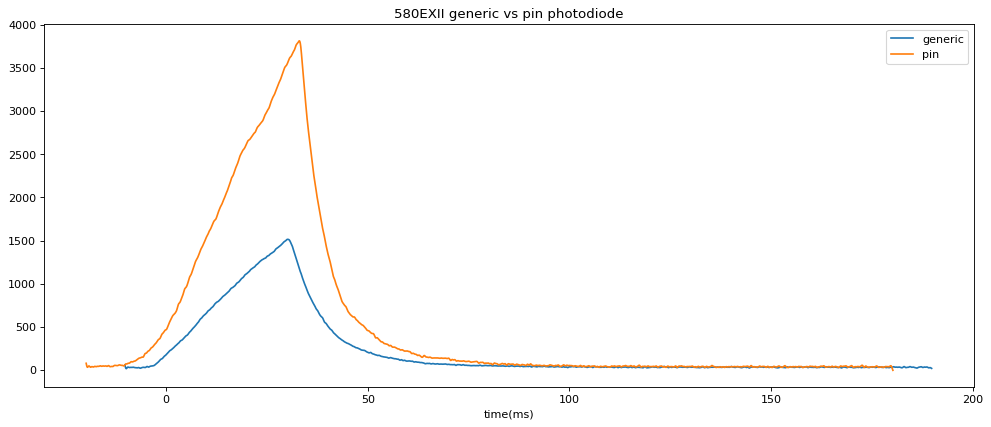

In [42]:
plot_signal([canon_flash.signals[0],canon_flash_pin.signals[0]], "580EXII generic vs pin photodiode", 
            labels=["generic", "pin"])

These are hard to compare, therefore we scale them vertically and translate them horizontally to align them.

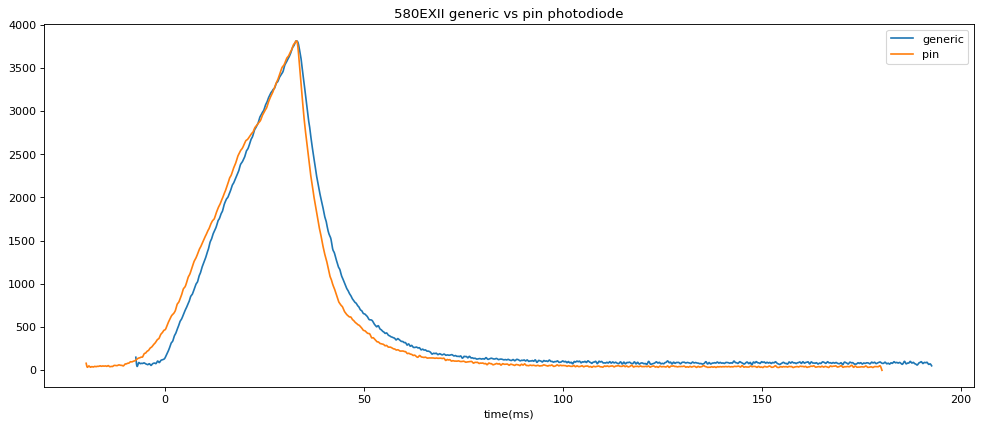

In [43]:
def align_signals(signals):
    # adjust the values vertically 
    tops = [ max(s.values) for s in signals ]
    top = max (tops)
    values_list = [ top/t * s.values for (s,t) in zip(signals, tops) ]
    # adjust the times horizontally
    top_times = [ s.times[s.values.argmax()] for s in signals ]
    top_time = max (top_times)
    times_list  = [ top_time-t0 + s.times for (s,t0) in zip(signals, top_times) ]
    return [ Signal(s.speed, times, values) for (s, values, times) in zip(signals, values_list, times_list) ]
    
aligned = align_signals([canon_flash.signals[0],canon_flash_pin.signals[0]])
plot_signal(aligned, "580EXII generic vs pin photodiode", 
            labels=["generic", "pin"])

The curves are very close to one another, certainly there is no benefit in using the fast pin diode.

## Sync delay
Another interesting thing to measure is the delay between triggering the flash and the actually flashing itself. Especially when using multiple flashes, one wants to operate them at the exact same time for high speed photography.

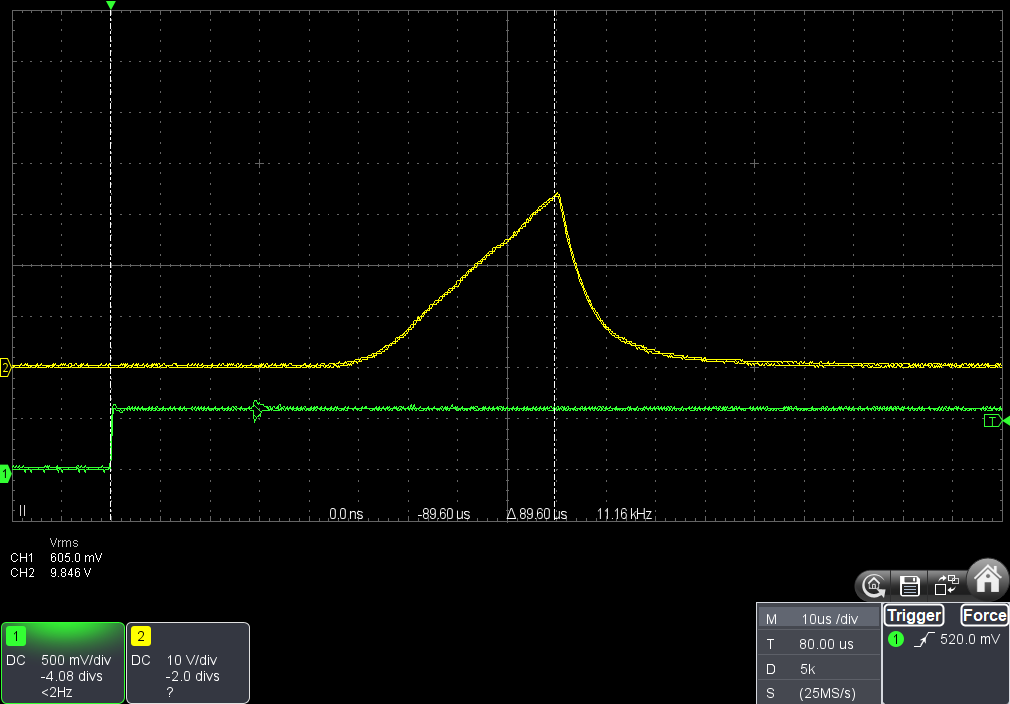

In [44]:
Image(dir + "pin-128.png", width=600, height=400)

As can be seen in the image, the delay between the th trigger signal (green) and the top of the flash curve (yellow) is about 86.8 $ \mu $s.
<br>
The measurement also shows some unexpected jitter in both the electrical signal of the trigger, as well as the optical signal of the flash. This might be some disturbance the flash produces on the trigger signal, maybe related to an infrared pre-flash that produced the optical signal.
<br>
We repeat the measurement above with the 1024x ND filter in place, and increasing the sensitively of the scope input.

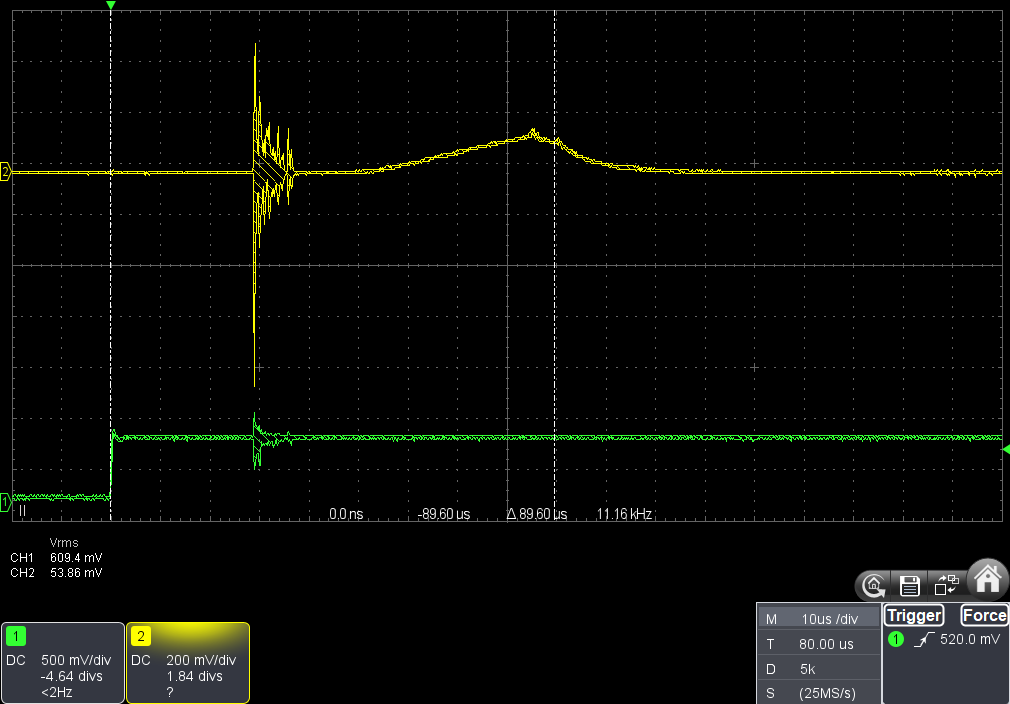

In [45]:
Image(dir + "pin-128-2x-pre.png", width=600, height=400)

We clearly see a strong signal compared to the actual flash output which is significantly reduced now.
We therefore conjecture that this is indeed a pre-flash, in infrared light and that the ND filter is more transparent in IR than in visible light.

## Multiple flashes
The question remains whether two flashes of the same time will fire simultaneously, when fired together. The figure below shows that indeed the light output from two flashes does add up nicely.
The curves for the combined flashes firing together matches well with the curves of the individual flashes added together.

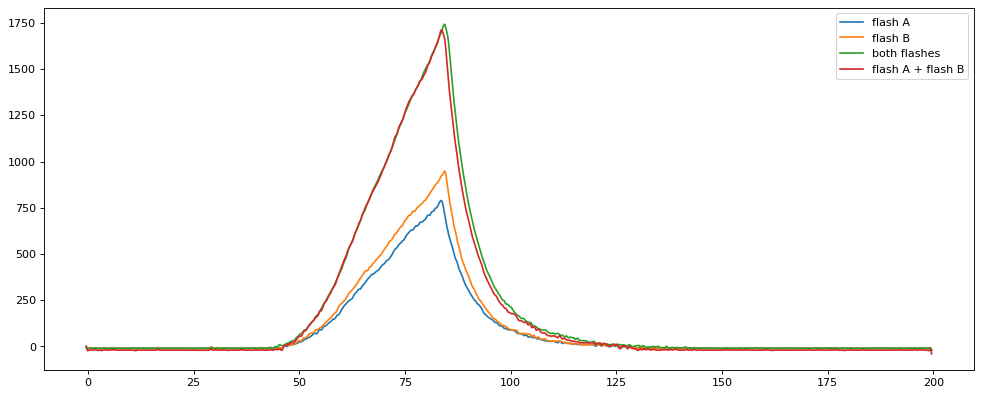

In [46]:
# Use column 3 for the data, since column 2 is the trigger signal
indices_a,  values_a  = get_signal(dir + "580EXII-pin/pin-128-a.csv", data_col=3)
indices_b,  values_b  = get_signal(dir + "580EXII-pin/pin-128-b.csv", data_col=3)
indices_ab, values_ab = get_signal(dir + "580EXII-pin/pin-128-ab.csv", data_col=3)
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(indices_a,  lp_filter(indices_a, values_a), label = "flash A")
plt.plot(indices_b,  lp_filter(indices_b, values_b), label = "flash B")
plt.plot(indices_ab, lp_filter(indices_ab, values_ab), label = "both flashes")
plt.plot(indices_a,  lp_filter(indices_ab, np.add(values_a, values_b)), label = "flash A + flash B")
plt.legend(loc="upper right")
plt.show()